In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    return run_query("SELECT name,type FROM sqlite_master WHERE type IN ('table','view')")

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [4]:
run_query(''' 
            WITH usa_tracks AS (
                SELECT
                    g.name genre,
                    t.track_id
                FROM track t
                INNER JOIN genre g
                ON t.genre_id = g.genre_id
                INNER JOIN invoice_line il
                ON t.track_id = il.track_id
                INNER JOIN invoice i
                ON il.invoice_id = i.invoice_id
                WHERE i.billing_country = "USA"
            )
            
            SELECT
                usa.genre,
                count(usa.track_id) tracks_sold,
                CAST(count(usa.track_id) AS FLOAT(4,2))/(SELECT 
                                                         count(*) 
                                                    FROM invoice_line il 
                                                    INNER JOIN invoice i 
                                                    ON il.invoice_id = i.invoice_id WHERE billing_country = "USA") percentage
            FROM usa_tracks usa
            GROUP BY 1
            ORDER BY 2 DESC
            LIMIT 10
          ''')

,genre,tracks_sold,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [5]:
top_genre_usa = run_query(''' 
            WITH usa_tracks AS (
                SELECT
                    g.name genre,
                    t.track_id
                FROM track t
                INNER JOIN genre g
                ON t.genre_id = g.genre_id
                INNER JOIN invoice_line il
                ON t.track_id = il.track_id
                INNER JOIN invoice i
                ON il.invoice_id = i.invoice_id
                WHERE i.billing_country = "USA"
            )
            
            SELECT
                usa.genre,
                count(usa.track_id) tracks_sold,
                CAST(count(usa.track_id) AS FLOAT)/(SELECT 
                                                         count(*) 
                                                    FROM invoice_line il 
                                                    INNER JOIN invoice i 
                                                    ON il.invoice_id = i.invoice_id 
                                                    WHERE billing_country = "USA") percentage
            FROM usa_tracks usa
            GROUP BY 1
            ORDER BY 2 DESC
            LIMIT 10
          ''')

<Container object of 10 artists>

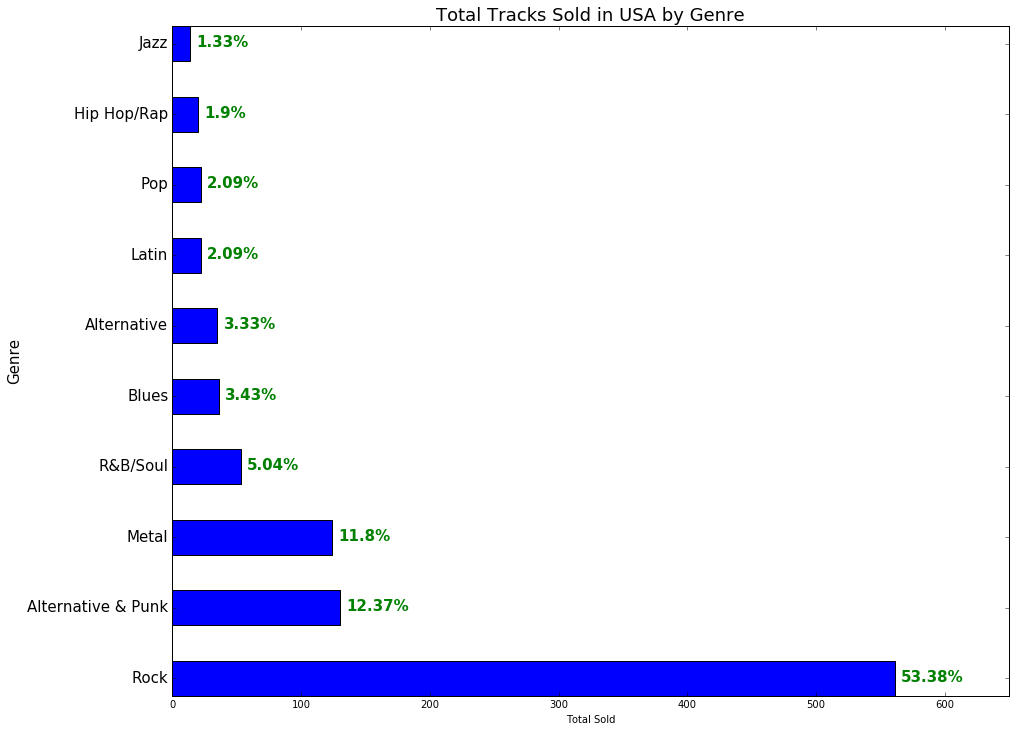

In [6]:
from numpy import arange
bar_heights = top_genre_usa["tracks_sold"].values
bar_positions = arange(10) + 0.75

fig, ax = plt.subplots(figsize=(15, 12))
ax.set_xlim(0,650)
ax.set_yticks(range(1,11))
ax.set_yticklabels(top_genre_usa["genre"].values,size=15)
ax.set_ylabel('Genre',size=15) 
ax.set_xlabel('Total Sold')
ax.set_title('Total Tracks Sold in USA by Genre',size=18)

for i, v in enumerate(top_genre_usa["percentage"].values):
    percent = str(round(v*100,2)) + "%"
    ax.text(top_genre_usa["tracks_sold"][i] + 5, i + 0.95, percent, color='green', fontweight='bold',size=15)
    
ax.barh(bar_positions,bar_heights, 0.5)


From our findings, we can conclude the heavier musical genres makes up the vast majority of track sales in the US with Rock (53.38%), followed by Alternative/Punk (12.37%), then Metal (11.8%). Those will below 10% of sales include R&B/Soul (5.04%), Blues (3.43%), and so on.

With regards to the decision on which three albums will make it to the record store, they are in order of sale estimates: 1) Red Tone, Slim Jim Bites, and Meteor and the Girls.

In [7]:
run_query('''
            WITH cust_by_country AS 
                (
                 SELECT
                   country,
                   count(customer_id) num_of_cust
                 FROM customer
                 GROUP BY 1 
                 ORDER BY 2 DESC 
                ),
            sales_by_country AS
                (
                 SELECT
                     c.country,
                     count(i.invoice_id) total_invoices,
                     sum(i.total) total_sales
                 FROM customer c
                 INNER JOIN invoice i
                 ON c.customer_id = i.customer_id
                 GROUP BY 1
                 ORDER BY 2 DESC
                )
            SELECT
                c.country,
                1 rank,
                c.num_of_cust,
                s.total_sales,
                s.total_sales/s.total_invoices average_order,
                s.total_sales/c.num_of_cust CLTV
            FROM sales_by_country s
            INNER JOIN cust_by_country c
            ON s.country = c.country
            WHERE c.num_of_cust > 1
            
            UNION
            
            SELECT
                "Others" country,
                0 rank,
                sum(c.num_of_cust) num_of_cust,
                sum(s.total_sales) total_sales,
                sum(s.total_sales)/sum(s.total_invoices) average_order,
                sum(s.total_sales)/sum(c.num_of_cust) CLTV
            FROM sales_by_country s
            INNER JOIN cust_by_country c
            ON s.country = c.country
            WHERE c.num_of_cust = 1
            GROUP BY 1
            
            ORDER BY rank DESC,total_sales DESC
          ''')

,country,rank,num_of_cust,total_sales,average_order,CLTV
0,USA,1,13,1040.49,7.942672,80.037692
1,Canada,1,8,535.59,7.047237,66.948750
2,Brazil,1,5,427.68,7.011148,85.536000
3,France,1,5,389.07,7.781400,77.814000
4,Germany,1,4,334.62,8.161463,83.655000
5,Czech Republic,1,2,273.24,9.108000,136.620000
6,United Kingdom,1,3,245.52,8.768571,81.840000
7,Portugal,1,2,185.13,6.383793,92.565000
8,India,1,2,183.15,8.721429,91.575000
9,Others,0,15,1094.94,7.448571,72.996000


In [8]:
country_sales_data = run_query('''
            WITH cust_by_country AS 
                (
                 SELECT
                   country,
                   count(customer_id) num_of_cust
                 FROM customer
                 GROUP BY 1 
                 ORDER BY 2 DESC 
                ),
            sales_by_country AS
                (
                 SELECT
                     c.country,
                     count(i.invoice_id) total_invoices,
                     sum(i.total) total_sales
                 FROM customer c
                 INNER JOIN invoice i
                 ON c.customer_id = i.customer_id
                 GROUP BY 1
                 ORDER BY 2 DESC
                )
            SELECT
                c.country,
                1 rank,
                c.num_of_cust,
                s.total_sales,
                s.total_sales/s.total_invoices average_order_val,
                s.total_sales/c.num_of_cust CLTV
            FROM sales_by_country s
            INNER JOIN cust_by_country c
            ON s.country = c.country
            WHERE c.num_of_cust > 1
            
            UNION
            
            SELECT
                "Others" country,
                0 rank,
                sum(c.num_of_cust) num_of_cust,
                sum(s.total_sales) total_sales,
                sum(s.total_sales)/sum(s.total_invoices) average_order_val,
                sum(s.total_sales)/sum(c.num_of_cust) CLTV
            FROM sales_by_country s
            INNER JOIN cust_by_country c
            ON s.country = c.country
            WHERE c.num_of_cust = 1
            GROUP BY 1
            
            ORDER BY rank DESC,total_sales DESC
          ''')

In [9]:
country_sales_data.drop('rank', axis=1, inplace=True)
country_sales_data

,country,num_of_cust,total_sales,average_order_val,CLTV
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Others,15,1094.94,7.448571,72.996000


([<matplotlib.patches.Wedge at 0x7fc5a8d07588>,
  <matplotlib.text.Text at 0x7fc5a8cc92b0>])

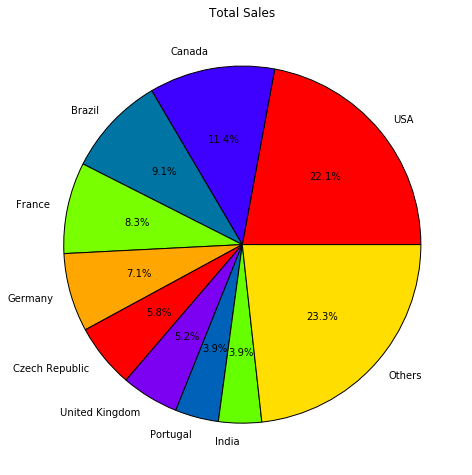

In [10]:
labels = country_sales_data["country"]
share = round(country_sales_data["total_sales"]/sum(country_sales_data["total_sales"])*100,2)

slices = [62, 39, 39, 38, 37, 21, 15,  9,  6,  7,  6,  5,  4, 3]
cmap = plt.cm.prism
colors = cmap(np.linspace(0., 1., len(slices)))

fig1,ax1 = plt.subplots(figsize=(8,8))
ax1.set_title("Total Sales")
ax1.pie(share,labels=labels,colors=colors,autopct='%1.1f%%')

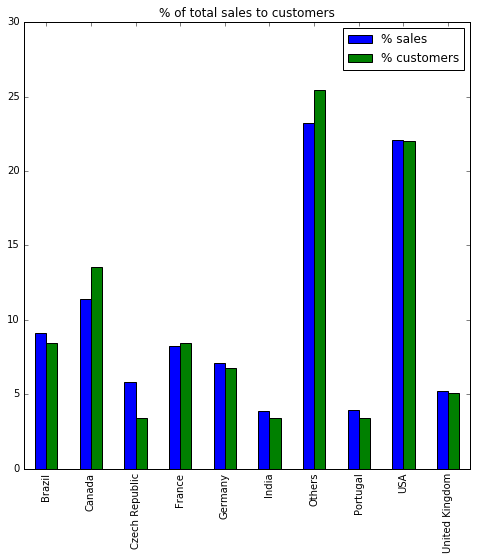

In [11]:
sales_to_customers = country_sales_data[["country","total_sales","num_of_cust"]]
total_sales = sum(sales_to_customers["total_sales"])
total_customers = sum(sales_to_customers["num_of_cust"])

data = {}

for idx,row in sales_to_customers.iterrows():
    pct_sales = round((row[1]/total_sales)*100,2)
    pct_customers = round((row[2]/total_customers)*100,2)
    data[row[0]] = [pct_sales,pct_customers]

data

sales_to_customers_new = pd.DataFrame(data).T
sales_to_customers_new.plot(kind="bar",figsize=(8,8),title="% of total sales to customers")
l =plt.legend()
l.get_texts()[0].set_text('% sales')
l.get_texts()[1].set_text('% customers')

In [12]:
average_order = sum(country_sales_data["average_order_val"])/country_sales_data.shape[0]

In [13]:
country_sales_data["pct away from avg sales"] = (country_sales_data["average_order_val"] - average_order)/average_order*100

<Container object of 10 artists>

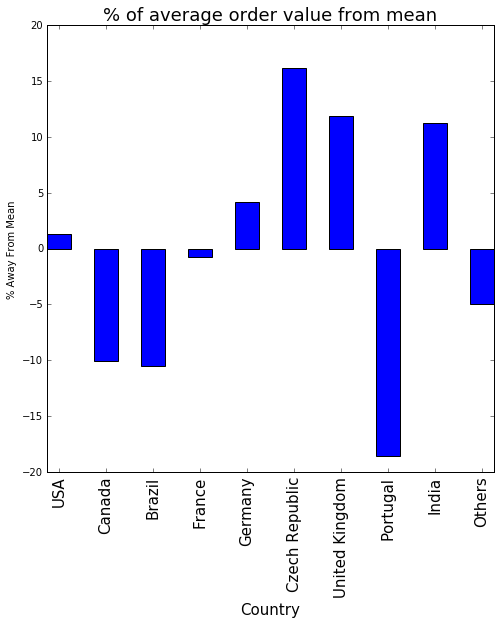

In [14]:
bar_heights = country_sales_data["pct away from avg sales"].values
bar_positions = arange(10) + 0.75

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(range(1,11))
ax.set_xticklabels(country_sales_data["country"].values,size=15,rotation=90)
ax.set_xlabel('Country',size=15) 
ax.set_ylabel('% Away From Mean')
ax.set_title('% of average order value from mean',size=18)
    
ax.bar(bar_positions,bar_heights, 0.5)

<Container object of 10 artists>

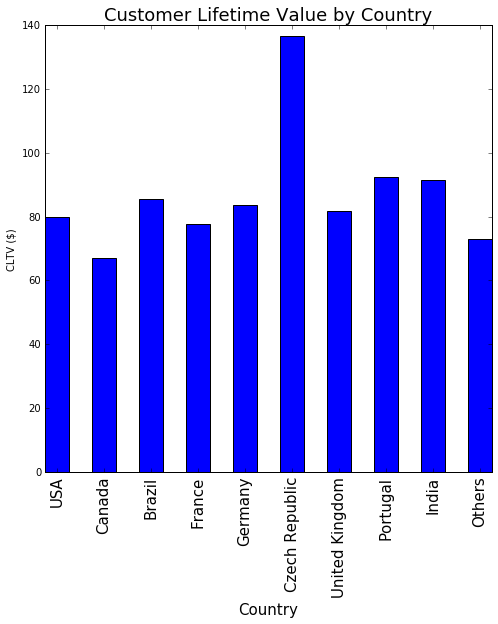

In [16]:
bar_heights = country_sales_data["CLTV"].values
bar_positions = arange(10) + 0.75

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks(range(1,11))
ax.set_xticklabels(country_sales_data["country"].values,size=15,rotation=90)
ax.set_xlabel('Country',size=15) 
ax.set_ylabel('CLTV ($)')
ax.set_title('Customer Lifetime Value by Country',size=18)
    
ax.bar(bar_positions,bar_heights, 0.5)

Opportunity is very apparent in Czech Republic, having high CLTV, and the highest average order value out of all countries. Additionally, it is the country with the highest percentage of total global sales, relative to its percentage of total customers. From this preliminary analysis (admittedly, more data is needed), there is a case to market strongly in this country. Other notable countries include India, and UK.

In [33]:
run_query('''
          WITH invoice_tracks AS (
              SELECT 
                 i.invoice_id,
                 a.album_id,
                 MIN(t.track_id) first_track_id
              FROM invoice i
              INNER JOIN invoice_line il
              ON i.invoice_id = il.invoice_id
              INNER JOIN track t
              ON il.track_id = t.track_id
              INNER JOIN album a
              ON t.album_id = a.album_id
              GROUP BY 1
          )

SELECT 
    album_purchased,
    COUNT(invoice_id) total,
    CAST(COUNT(invoice_id) AS FLOAT)/(SELECT COUNT(*) FROM invoice) percentage
FROM (
       SELECT
         *,
         CASE
            WHEN
            (
              SELECT t.track_id 
              FROM track t
              WHERE t.album_id = (SELECT DISTINCT it.album_id)

              EXCEPT

              SELECT il.track_id FROM invoice_line il
              WHERE il.invoice_id = it.invoice_id
             )
             IS NULL THEN 'Yes'
             ELSE 'No'
             END AS 'album_purchased'
              
       FROM invoice_tracks it
       )
GROUP BY 1

          ''')

,album_purchased,total,percentage
0,No,497,0.809446
1,Yes,117,0.190554


In [54]:
albums_vs_tracks_2 = '''
WITH invoice_first_track AS 
    (
     SELECT
         il.invoice_id invoice_id,
         i.customer_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1, 2
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ifs.*,
        t.album_id,
        CASE
            WHEN
                (
                 SELECT t3.track_id FROM track t3
                 WHERE t3.album_id = t.album_id
                 
                 EXCEPT
                 
                 SELECT il2.track_id FROM invoice_line il2
                 INNER JOIN invoice i2 ON i2.invoice_id = il2.invoice_id
                 INNER JOIN track t2 ON t2.track_id = il2.track_id
                 WHERE
                         il2.invoice_id <= ifs.invoice_id
                     AND i2.customer_id = ifs.customer_id
                     AND t2.album_id = t.album_id

                ) IS NULL THEN "yes"
            ELSE "no"
        END AS "album_purchase"
    FROM invoice_first_track ifs
    INNER JOIN track t ON ifs.first_track_id = t.track_id
    )
GROUP BY 1
'''

run_query(albums_vs_tracks_2)

,album_purchase,number_of_invoices,percent
0,no,475,0.773616
1,yes,139,0.226384


Album purchases account for 22.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.